# Exploring Faster R-CNN with LaRA Traffic Light Dataset

Fast R-CNNs were once the most computationally efficient region-based object detection networks.  However, the region proposal portion of the detection algorithm proved to be a major bottleneck in the computation.  Stimulated to produce a more efficient model, the authors of 'Faster R-CNN' introduced the Region Proposal Network (RPN).  The RPN is a fully-convolutional network that infers object bounds and objectness scores.  The RPN is integrated into the detection network by sharing convolutional features.  This contrasts with previous object detection models in which region proposals were made outside the detection network.  This integration results in a more efficient computation.  It is faster and requires fewer proposals per image.  In addition, Faster-RCNN has achieved higher accuracy on standard datasets than Fast R-CNN.

In this report, I test the performance of Faster R-CNN on the LaRA Traffic Light Dataset (found here: http://www.lara.prd.fr/benchmarks/trafficlightsrecognition).  This dataset consists of 9,168 instances of traffic lights across over 6,000 images that were taken via a vehicle driving on the dense streets of Paris.  This dataset is particularly challenging, because the traffic lights in the images are typically very small, and determining whether they are red, orange, or green is difficult in an urban setting that contains many other sources of distracting light.  In contrast to the original paper which used VGG16, the backbone network that I use is ResNet50.

Measuring the performance of an object detection model is more delicate than it is for image classification.  The intersection-over-union (IOU) metric is usually employed to determine whether the bounding boxes have adequately identified the ground truth.  However, as it is almost impossible for a network to perfectly guess the ground truth bounding boxes, a mere 'right' or 'wrong' approach is inadequate.  Therefore, a threshold other than 100% must be used.  If the IOU is above this threshold, and the object within the bounding box is correctly classfied, then the object is considered detected.  To determine an adequate threshold, the model is tested at a range of values for the threshold.  The precision and recall are measured for every value.  Then, looking at a precision-recall curve, we can determine which thresholds best balance the precision and recall.  The Average Precision (AP), which is a function of the precision and recall, is a metric that is often used to reduce the precision-recall curve into a single number.  This approach outlined here will be used to evalute the Faster R-CNN on the LaRA dataset.  Along the way, since the smallness of the objects in the images is a concern, I will be evaluating the effects of the sizes of the objects on the performance of the model. 


## Importing and Creating Dataset

In [1]:
import pandas as pd
from lxml import etree as ET
import torch
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
import os
import glob as glob
!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm
import time



     |████████████████████████████████| 117 kB 8.7 MB/s 
     |████████████████████████████████| 948 kB 41.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=fc67dc9f3d0eb6da2d49a9ca5710993b134f0ff3dc5a766e489604207529ac20
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
#Getting the data

!wget http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_JPG.zip
!unzip Lara_UrbanSeq1_JPG.zip
!wget http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_GroundTruth_cvml.xml
!wget http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_GroundTruth_GT.txt

Streaming output truncated to the last 5000 lines.
  inflating: Lara3D_UrbanSeq1_JPG/frame_006201.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006202.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006203.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006204.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006205.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006206.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006207.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006208.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006209.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006210.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006211.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006212.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006213.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006214.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006215.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006216.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006217.jpg  
  inflating: Lara3D_UrbanSeq1_JPG/frame_006218.j

In [4]:
# The dataset contains a few thousand images that do not contain any traffic lights.  So, we need 
# a list of image names that do contain traffic lights.  Duplicates will appear in the list if there
# is more than 1 light in the image

df_have_lights = pd.read_csv('/content/Lara_UrbanSeq1_GroundTruth_GT.txt', sep=" ",header=None)

have_lights = list(df_have_lights[2])

In [5]:
# The website states that there are 9,168 lights - verifying

len(have_lights)

9168

In [6]:
# Setting up the dataset class

class TrafficLights(Dataset):
    def __init__(self, dir_path, width, height, classes, have_lights_list, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        
        #We will need to transform the image to 512x512
        
        self.height = height
        self.width = width
        
        self.classes = classes
        self.have_lights = have_lights_list
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = [i for i in self.all_images if int(i[6:12]) in self.have_lights]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        image_name = self.all_images[idx]
        frame = int(image_name[6:12])
        image_path = os.path.join(self.dir_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))

        annot_file_path = '/content/Lara_UrbanSeq1_GroundTruth_cvml.xml'
        
        
        #Using etree to manipulate the XML file
        boxes = []
        labels = []
        tree = ET.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        it = './/frame[@number=' +'\''+ str(frame) + '\'' + ']'

        boxes_info = tree.find(it).findall(".//box")
        
        #We will need the coordinates of the groundtruth boxes
        for b in boxes_info:
            dim_dict = b.attrib
            xmin = int(dim_dict['xc']) + int(dim_dict['w'])/2
            xmax = int(dim_dict['xc']) - int(dim_dict['w'])/2
            ymin = int(dim_dict['yc']) + int(dim_dict['h'])/2
            ymax = int(dim_dict['yc']) - int(dim_dict['h'])/2
            xmax_final = (xmin/image_width)*self.width
            xmin_final = (xmax/image_width)*self.width
            ymax_final = (ymin/image_height)*self.height
            ymin_final = (ymax/image_height)*self.height
            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        labels_info = tree.find(it).findall(".//subtype")
        for l in labels_info:
            labels.append(self.classes.index(l.text))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target
    
    def __len__(self):
        return len(self.all_images)

## Training the Model

In [7]:
# define the tranform
def get_transform():
    return A.Compose([
#        A.Flip(0.5),
#        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

#We will need this function to deal with images with multiple objects
def collate_fn(batch):
    return tuple(zip(*batch))

#This class will aid with computing averages of all the losses during training
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
    # Progress Bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_dict)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
        
    return train_loss_list

def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # Progress Bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_dict)
        val_loss_hist.send(loss_value)
        val_itr += 1
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
        
    return val_loss_list

In [8]:
#Setting variables for training

BATCH_SIZE = 8
RESIZE_TO = 512
NUM_EPOCHS = 15
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
CLASSES = ['background', 'stop', 'go', 'warning', 'ambiguous']
NUM_CLASSES = 5

In [9]:
# Defining datasets.  We don't need very many images for the transfer learning.  Also, due to time constraints,
# we will only be looking at 500 testing images.  The rest of the images will not be used.  Luckily, most of the images
# are near duplicates, e.g., the car taking photos was just sitting at a stop light.

train_dataset, val_dataset, test_dataset, not_use = random_split(TrafficLights('/content/Lara3D_UrbanSeq1_JPG', 
                                                                                RESIZE_TO, RESIZE_TO, 
                                                                                CLASSES, have_lights, 
                                                                                transforms=get_transform()), 
                                                                                (200,28,500,5500))

In [11]:
#Creating DataLoaders

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [12]:
#This cell executes the training

model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# These lists of dictionaries store the loss histories
train_loss_list = []
val_loss_list = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    train_loss_hist.reset()
    val_loss_hist.reset()
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(val_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]


EPOCH 1 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #1 train loss: 29.605
Epoch #1 validation loss: 0.992
Took 0.668 minutes for epoch 1

EPOCH 2 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #2 train loss: 0.601
Epoch #2 validation loss: 0.244
Took 0.658 minutes for epoch 2

EPOCH 3 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #3 train loss: 0.202
Epoch #3 validation loss: 0.182
Took 0.661 minutes for epoch 3

EPOCH 4 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #4 train loss: 0.151
Epoch #4 validation loss: 0.137
Took 0.659 minutes for epoch 4

EPOCH 5 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #5 train loss: 0.132
Epoch #5 validation loss: 0.127
Took 0.670 minutes for epoch 5

EPOCH 6 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #6 train loss: 0.107
Epoch #6 validation loss: 0.112
Took 0.679 minutes for epoch 6

EPOCH 7 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #7 train loss: 0.098
Epoch #7 validation loss: 0.103
Took 0.665 minutes for epoch 7

EPOCH 8 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #8 train loss: 0.088
Epoch #8 validation loss: 0.129
Took 0.668 minutes for epoch 8

EPOCH 9 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #9 train loss: 0.110
Epoch #9 validation loss: 0.102
Took 0.670 minutes for epoch 9

EPOCH 10 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #10 train loss: 0.094
Epoch #10 validation loss: 0.103
Took 0.672 minutes for epoch 10

EPOCH 11 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #11 train loss: 0.078
Epoch #11 validation loss: 0.083
Took 0.678 minutes for epoch 11

EPOCH 12 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #12 train loss: 0.068
Epoch #12 validation loss: 0.082
Took 0.677 minutes for epoch 12

EPOCH 13 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #13 train loss: 0.060
Epoch #13 validation loss: 0.080
Took 0.682 minutes for epoch 13

EPOCH 14 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #14 train loss: 0.060
Epoch #14 validation loss: 0.073
Took 0.680 minutes for epoch 14

EPOCH 15 of 15
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #15 train loss: 0.055
Epoch #15 validation loss: 0.069
Took 0.682 minutes for epoch 15


In [13]:
#Saving model

torch.save(model.state_dict(), 'model.pth')

In [27]:
# Need to change the datatypes of the dictionary values from tensors to just floats

train_loss=[]
for i in train_loss_list:
    d = {}    
    for j in i:
        d[j] = i[j].item()
    train_loss.append(d)

val_loss=[]
for i in val_loss_list:
    d = {}    
    for j in i:
        d[j] = i[j].item()
    val_loss.append(d)

In [30]:
#Saving results

import csv
keys = train_loss[0].keys()
with open('train_losses.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(train_loss)

keys = val_loss[0].keys()
with open('val_losses.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(val_loss)

## Results of Training

In [36]:
#Getting the losses into lists

train_loss_class = [i['loss_classifier'] for i in train_loss]
train_loss_box_reg = [i['loss_box_reg'] for i in train_loss]
train_loss_obj = [i['loss_objectness'] for i in train_loss]
train_loss_rpn = [i['loss_rpn_box_reg'] for i in train_loss]

val_loss_class = [i['loss_classifier'] for i in val_loss]
val_loss_box_reg = [i['loss_box_reg'] for i in val_loss]
val_loss_obj = [i['loss_objectness'] for i in val_loss]
val_loss_rpn = [i['loss_rpn_box_reg'] for i in val_loss]

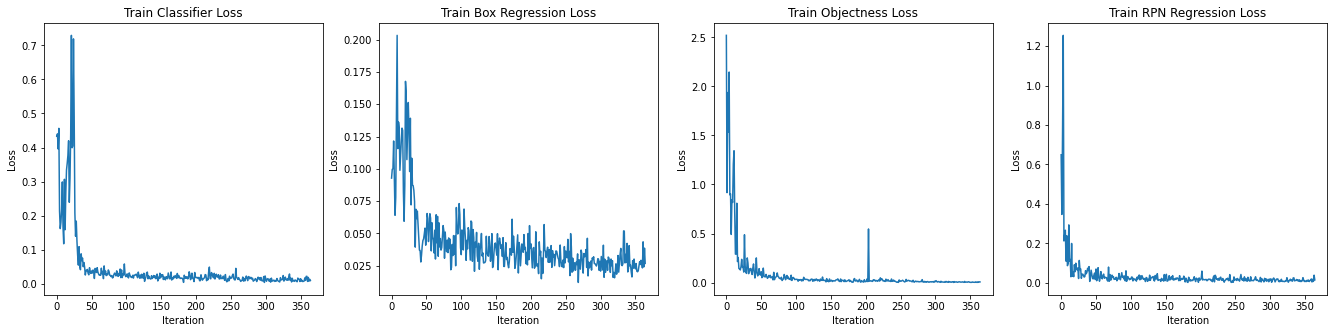

In [54]:
#Graphing Training Results

fig, axs = plt.subplots(1, 4, figsize=(23,5))
axs[0].plot(range(365), train_loss_class[10:])
axs[0].set_title('Train Classifier Loss')
axs[1].plot(range(365), train_loss_box_reg[10:])
axs[1].set_title('Train Box Regression Loss')
axs[2].plot(range(365), train_loss_obj[10:])
axs[2].set_title('Train Objectness Loss')
axs[3].plot(range(365), train_loss_rpn[10:])
axs[3].set_title('Train RPN Regression Loss')


for ax in axs.flat:
    ax.set(xlabel='Iteration', ylabel='Loss')

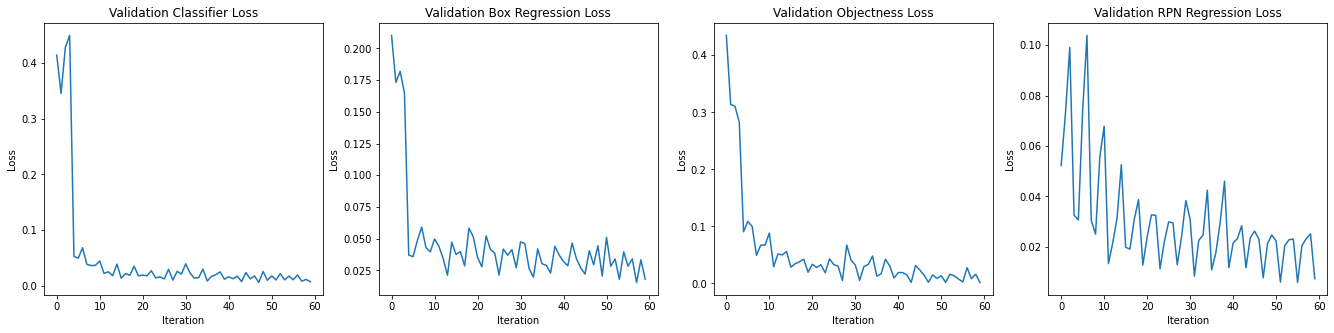

In [53]:
#Graphing validation results

fig, axs = plt.subplots(1, 4, figsize=(23,5))
axs[0].plot(range(60), val_loss_class)
axs[0].set_title('Validation Classifier Loss')
axs[1].plot(range(60), val_loss_box_reg)
axs[1].set_title('Validation Box Regression Loss')
axs[2].plot(range(60), val_loss_obj)
axs[2].set_title('Validation Objectness Loss')
axs[3].plot(range(60), val_loss_rpn)
axs[3].set_title('Validation RPN Regression Loss')


for ax in axs.flat:
    ax.set(xlabel='Iteration', ylabel='Loss')

The training and validation losses are graphed above.  The classifier loss measures how well the model determines the type of object (i.e., whether the light is red, green, orange, ambiguous).  The box regression loss looks at how close the predicted bounding boxes are to the ground truth.  The objectness loss measures how well the network detects an object (regardless of class, i.e., whether there is an object or not).  The RPN regression loss looks at how well the RPN is doing at proposing bounding boxes.  Because I started with a pretrained model, all that was required here was transfer learning.  Therefore, fewer epochs were required for the model to converge.  Experimentation revealed that about 15 epoch were sufficient, after which the validation losses began to increase.  Due to memory constraints, the batch size was 8.  Since the dataset is small, this didn't pose a problem.  Instead of having the epochs on the x-axis, I have the the number of batches (or iterations).  We can see that before 50 training iterations, the losses are all very low and slowly flatten.  The same is true for the validation losses before 10 validation iterations.  There doesn't seem to be anything too significant to note about the differences of the various losses.  However, it does appear that the regression losses varied a bit more.

## A quick remark about the distribution of examples in the dataset

Before getting to the implementation of the testing, I first want to discuss something that came up during my review of the testing results regarding the counts of the various classes in the dataset.

In [2]:
counts_test = [0, 0, 0, 0]

for batch in test_loader:
    images, targets = batch
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
    for t in range(len(targets)):
        labels = targets[t]['labels']
        for l in range(labels.size()[0]):
            label = labels[l] - 1
        counts_test[label] += 1


In [3]:
counts_val = [0,0,0,0]

for batch in val_loader:
    images, targets = batch
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
    for t in range(len(targets)):
        labels = targets[t]['labels']
        for l in range(labels.size()[0]):
            label = labels[l] - 1
        counts_val[label] += 1


In [4]:
counts_train = [0,0,0,0]

for batch in train_loader:
    images, targets = batch
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
    for t in range(len(targets)):
        labels = targets[t]['labels']
        for l in range(labels.size()[0]):
            label = labels[l] - 1
        counts_train[label] += 1

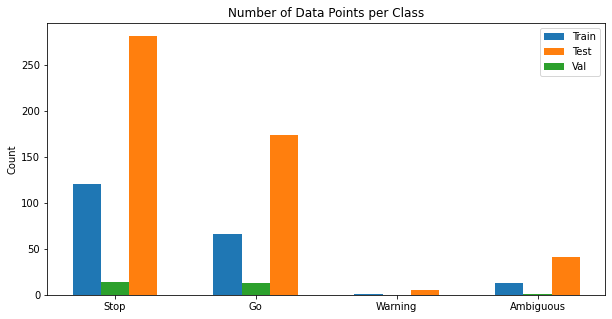

In [333]:
fig =  plt.subplots(figsize=(10,5))
x_axis = np.arange(len(counts_val))
plt.bar(x_axis -0.2, counts_train, width=0.2, label = 'Train')
plt.bar(x_axis +0.2, counts_test, width=0.2, label = 'Test')
plt.bar(x_axis, counts_val, width=0.2, label='Val')
plt.xticks(range(0,4), ['Stop', 'Go', 'Warning', 'Ambiguous'])
plt.title('Number of Data Points per Class')
plt.ylabel('Count')
plt.legend()
plt.show()

Above are graphed the counts of each class for each dataset.  The class 'Stop' of course refers to a red light, and the class 'Go' refers to a green light.  'Warning' refers to a yellow light (or orange, as the website calls them).  The 'Ambiguous' class is used to classify images in which the lights are, for example, too small or blurry.  It can be seen that there was almost no training examples of the 'warning' class in the training dataset.  This is due to the fact that there were only 58 examples in the entire dataset.  This makes sense, as yellow lights are brief in duration.  Unfortunately, I did not notice that when I randomly selected from the full dataset that I did not select enough examples of this class.  Therefore, it seems prudent that I not test the model's performance on this class due to an insufficient quantity of data.

A another quick note about the counts is that there are many more images of stop lights than green lights.  This may have an effect on the test results.

## Testing the Network

As noted in the introduction, I will be computing the precision-recall curves for each class using various thresholds for the IOU.  I will also be looking at the average precision for each class.

In [341]:
#Functions for performing testing

#This function takes predicted and target boxes and returns the width, height, and top-left corner point
def get_boxes(pred, targ):

    pred_x = pred[0].item()
    pred_y = pred[1].item()
    pred_w = pred[2].item() - pred[0].item()
    pred_l = pred[3].item() - pred[1].item()
    pred_bx = [pred_x, pred_y, pred_w, pred_l]

    targ_x = targ[0].item()
    targ_y = targ[1].item()
    targ_w = targ[2].item() - targ[0].item()
    targ_l = targ[3].item() - targ[1].item()
    targ_bx = [targ_x, targ_y, targ_w, targ_l]
    return pred_bx, targ_bx


#Function for computing IOU
def intersection_over_union(gt_box, pred_box):
    inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [min(gt_box[0]+gt_box[2], 
                                  pred_box[0]+pred_box[2]), min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection

    iou = intersection / union
    
    #If the IOU is an invalid number, this means that there is no intersection, so must be set to 0
    
    if iou > 1 or iou < 0:
        iou = 0
    return iou

# This function computes the target box that has the greatest IOU for the predicted box.
# This way we can associate each prediction with a target
def get_max_iou(pred, targ, idx):
    ious = []
    if pred['scores'][idx] > 0.0:
        for j in range(targ['boxes'].size()[0]):
            pred_bx, targ_bx = get_boxes(pred['boxes'][idx], targ['boxes'][j])
            iou = intersection_over_union(targ_bx, pred_bx)
            ious.append(iou)
        max_iou = max(ious)
        max_idx = ious.index(max_iou)
    return max_iou, max_idx

# This function updates the confusion matricies that store false-positves, true-negatives, etc.,
# that are needed to compute precision and recall
def update_cms(pred, targ, thresh, cms):
    model.eval()
    for i in range(pred['boxes'].size()[0]):
        max_iou, max_idx = get_max_iou(pred, targ, idx)
        targ_label = targ['labels'][max_idx].item()
        pred_label = pred['labels'][i].item()
        
        #The following are the conditions used to determine false-positive, false-negative, etc.
        
        if max_iou > thresh and targ_label == pred_label:
            cms[targ_label-1][0,0] +=1
            for j in range(len(cms)):
                if j != (targ_label-1):
                    cms[j][1,1] += 1
        elif max_iou > thresh and targ_label != pred_label:
            cms[pred_label-1][1,0] += 1
            cms[targ_label-1][0,1] += 1
            for j in range(len(cms)):
                if j != (targ_label-1) and j != (pred_label-1):
                    cms[j][1,1] += 1
        elif max_iou <= thresh and targ_label == pred_label:
            cms[pred_label-1][0,1] += 1
            for j in range(len(cms)):
                if j != (targ_label-1):
                    cms[j][1,1] += 1
        elif max_iou <= thresh and targ_label != pred_label:
            cms[targ_label-1][0,1] += 1
            for j in range(len(cms)):
                if j != (targ_label-1):
                    cms[j][1,1] += 1
    return cms

#This function initiates the confusion matricies
def get_cms(test_loader, thresh):
    stop = np.zeros((2,2))
    go = np.zeros((2,2))
    warning = np.zeros((2,2))
    ambiguous = np.zeros((2,2))

    cms = [stop, go, warning, ambiguous]

    for batch in test_loader:
        images, targets = batch
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            model.eval()
            pred = model(images, targets) 
    for i in range(len(images)):
        cms = update_cms(pred[i], targets[i], thresh, cms)
    return cms

#Gets precision/recall for a given confusion matrix
def precision_recall(cm):
    precision = cm[0,0]/(cm[1,0]+cm[0,0])
    recall = cm[0,0]/(cm[0,1]+cm[0,0])
    return precision, recall

# Gets precision/recall for list of confusion matricies and stores in list of tuples.
# This will be helpful for graphing, computing AP
def get_precision_recall(cms):
    p_and_r = []
    for i in range(len(cms)):
        precision, recall = precision_recall(cms[i])
        p_and_r.append((precision, recall))
    return p_and_r

#Gets AP for each class as function of precision and recall
def get_average_precision(p_and_r, thresholds):
    avg_precision = 0
    p_and_r.append((1,0))
    for i in range(len(thresholds)):
        avg_precision += (p_and_r[i][1]-p_and_r[i+1][1])*p_and_r[i][0]
    return avg_precision




In [59]:
#Perform test

#I will be looking at threshold between 0.1 and 0.9 and 0.05 increments
thresholds = [0.0 + 0.05*i for i in range(2,19)]

stop_p_and_r = []
go_p_and_r = []
warn_p_and_r = []
amb_p_and_r = []

for thresh in thresholds:
    print('Running Threshold', round(thresh,2))
    cms = get_cms(test_loader, thresh)
    p_and_r = get_precision_recall(cms)
    stop_p_and_r.append(p_and_r[0])
    go_p_and_r.append(p_and_r[1])
    warn_p_and_r.append(p_and_r[2])
    amb_p_and_r.append(p_and_r[3])




Running Threshold 0.1
Running Threshold 0.15
Running Threshold 0.2
Running Threshold 0.25
Running Threshold 0.3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in double_scalars


Running Threshold 0.35
Running Threshold 0.4
Running Threshold 0.45
Running Threshold 0.5
Running Threshold 0.55
Running Threshold 0.6
Running Threshold 0.65
Running Threshold 0.7
Running Threshold 0.75
Running Threshold 0.8
Running Threshold 0.85
Running Threshold 0.9


In [72]:
#Turning list of tuples in to separate lists for graphing

prec_stop = [i[0] for i in stop_p_and_r]
rec_stop = [i[1] for i in stop_p_and_r]

prec_go = [i[0] for i in go_p_and_r]
rec_go = [i[1] for i in go_p_and_r]

prec_amb = [i[0] for i in amb_p_and_r]
rec_amb = [i[1] for i in amb_p_and_r]

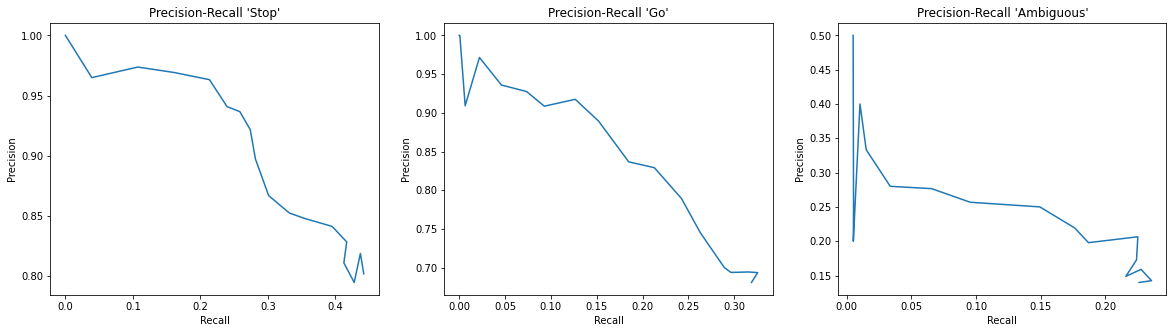

In [74]:
#Plotting results

fig, axs = plt.subplots(1, 3, figsize=(20,5))
axs[0].plot(rec_stop, prec_stop)
axs[0].set_title('Precision-Recall \'Stop\'')
axs[1].plot(rec_go, prec_go)
axs[1].set_title('Precision-Recall \'Go\'')
axs[2].plot(rec_amb, prec_amb)
axs[2].set_title('Precision-Recall \'Ambiguous\'')

for ax in axs.flat:
    ax.set(xlabel='Recall', ylabel='Precision')

Above are the precision-recall curves.  The threshold start at 0.1, which is plotted on the far right of the curve, and goes to 0.9 which is the far left of the curve.  The curve for the 'Stop' class looks like what we should expect.  When the IOU threshold is high, the precision is around 1.0 and the recall is low, around 0.0.  When the threshold is low, the precision is very low, but the recall is very high.  This makes sense, because when the threshold is low, it is 'easier' for the network to assign a positive detection when perhaps there shouldn't be, resulting in more false positives.  When the threshold is high, there is high precision, because only the most perfectly fitted bounding boxes will pass the test.  However, this means that many objects will not be detected that should be.  What is nice about the 'Stop' curve is that there is a clear turning point around the middle of the curve, when the threshold is about 0.6.  Thus, 0.6 may be a good threshold, because at this point the precision and recall are well balanced.  While the 'Go' curve exhibits the expected direction of a precision-recall curve (though more erratically), there doesn't seem to be a nice drop-off point, making it more difficult to determine a good threshold.  The 'Ambiguous' curve is considerably more unstable and unexpectedly flattens out in the middle.  Perhaps these discrepencies are due to the fact that 'Stop' had more examples in the dataset, while 'Ambiguous' did not.  Perhaps, in addition, the 'Ambiguous' class did not perform as well because, well, the objects were ambiguous.

An important thing to note for all of the curves is the overall low recall levels.  We would normally expect these to be much higher.  This indicates that the network is not sensitive enough.  There are too many traffic lights that aren't being detected that should be.

Next, I look at average precision.

In [75]:
ap_stop = get_average_precision(stop_p_and_r, thresholds)
ap_go = get_average_precision(go_p_and_r, thresholds)
ap_amb = get_average_precision(amb_p_and_r, thresholds)

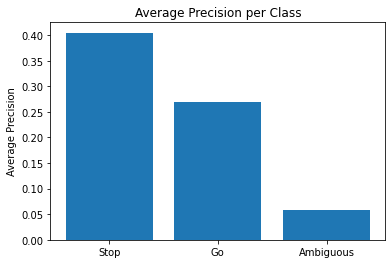

In [79]:
plt.bar(['Stop', 'Go', 'Ambiguous'], [ap_stop, ap_go, ap_amb])
plt.title('Average Precision per Class')
plt.ylabel('Average Precision')
plt.show()

The average precision (AP) for each class is graphed above.  Given the precision-recall curves, these results are expected.  The 'Stop' class performed the best, and the 'Ambiguous' class performed the worst.

Finally, it is time to take a look at a few images.

## Visualizing the Results

In [357]:
#This function plots the images together with the bounding boxes, scores, and IOUs

def make_figure(image, target, prediction):
    fig, ax = plt.subplots(1,2, figsize=(20,25))

    ax[0].imshow(image.cpu().permute(1,2,0))
    ax[1].imshow(image.cpu().permute(1,2,0))

    targ_labels = [CLASSES[target['labels'][i].item()] for i in range(target['labels'].size()[0])]
    pred_labels = [CLASSES[prediction['labels'][i].item()] for i in range(prediction['labels'].size()[0])]
    pred_scores = [round(prediction['scores'][i].item(),2) for i in range(prediction['scores'].size()[0])]
  
    ax[0].set_title('Prediction')
    ax[1].set_title('Target')
    
    #Need to get the predicted boxes, IOU, and score
    for i in range(prediction['boxes'].size()[0]):
        width = prediction['boxes'][i,2].item() - prediction['boxes'][i,0].item()
        height = prediction['boxes'][i,3].item() - prediction['boxes'][i,1].item()

        max_iou, max_idx = get_max_iou(prediction, target, i)

        p_bx, t_bx = get_boxes(prediction['boxes'][i], target['boxes'][max_idx])
        iou = round(intersection_over_union(t_bx, p_bx), 2)

        rect = patches.Rectangle((prediction['boxes'][i,0],prediction['boxes'][i,1], 97), width, height, 
                               linewidth=1, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text(prediction['boxes'][i,0]-5,(prediction['boxes'][i,1]-10),str(pred_labels[i]),verticalalignment='top',
              color='white',fontsize=10,weight='bold')
        ax[0].text(prediction['boxes'][i,0]-15,(prediction['boxes'][i,3]+5),'Score:'+str(pred_scores[i]),verticalalignment='top',
              color='white',fontsize=10,weight='bold')
        ax[0].text(prediction['boxes'][i,0]-15,(prediction['boxes'][i,3]+15),'IOU:'+str(iou),verticalalignment='top',
              color='white',fontsize=10,weight='bold')
        
    #Need to get boudning boxes for ground truth
    for i in range(target['boxes'].size()[0]):
        width = target['boxes'][i,2].item() - target['boxes'][i,0].item()
        height = target['boxes'][i,3].item() - target['boxes'][i,1].item()
        rect = patches.Rectangle((target['boxes'][i,0],target['boxes'][i,1], 97),width , height, linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(target['boxes'][i,0]-5,(target['boxes'][i,1]-10),str(targ_labels[i]),verticalalignment='top',
                  color='white',fontsize=10,weight='bold')
        
    plt.show()

In [166]:
# This cell just captures any example for demonstration

image = None
target = None
prediction = None
for batch in test_loader:
    images, targets = batch
    images = list(image.to(DEVICE) for image in images)
    image = images[3]/255
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
    target = targets[3]
    with torch.no_grad():
        model.eval()
        pred = model(images, targets) 
        prediction = pred[3]
    break


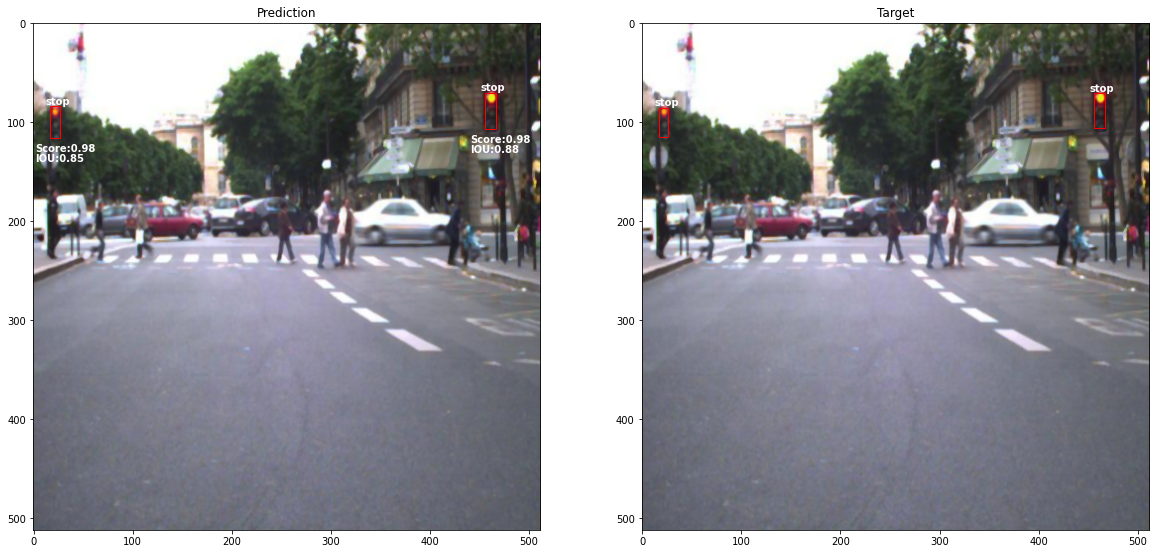

In [352]:
make_figure(image, target, prediction)

Above is a random example from the test dataset.  We can see that the prediction is almost spot on.  The IOUs are almost 0.9 and the objectness scores are almost 1.0.  The success of this example might be attributable to the clear visibility of the two lights.  However, they are fairly small as expected, so this example is impressive.

Something that strikes me upon seeing the target bounding boxes is how tight they are.  They don't seem to capture the entire body of the traffic lights.  They only enclose the lights themselves.  I wonder if this was what was intended by the creators of the dataset.  I am inclined to think that such tight boxes would make training the network more difficult.

In [229]:
# This cell captures a 'bad' image

im_bad = None
targ_bad = None
pred_bad = None
cont = True
for batch in test_loader:
    if cont == False:
        break
    images, targets = batch
    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
    with torch.no_grad():
        model.eval()
        pred = model(images, targets) 
    for i in range(len(images)):
        if pred[i]['scores'][0] > 0.5 and pred[i]['scores'][0] < 0.6:
            im_bad = images[i]/255
            targ_bad = targets[i]
            pred_bad = pred[i]
            cont = False


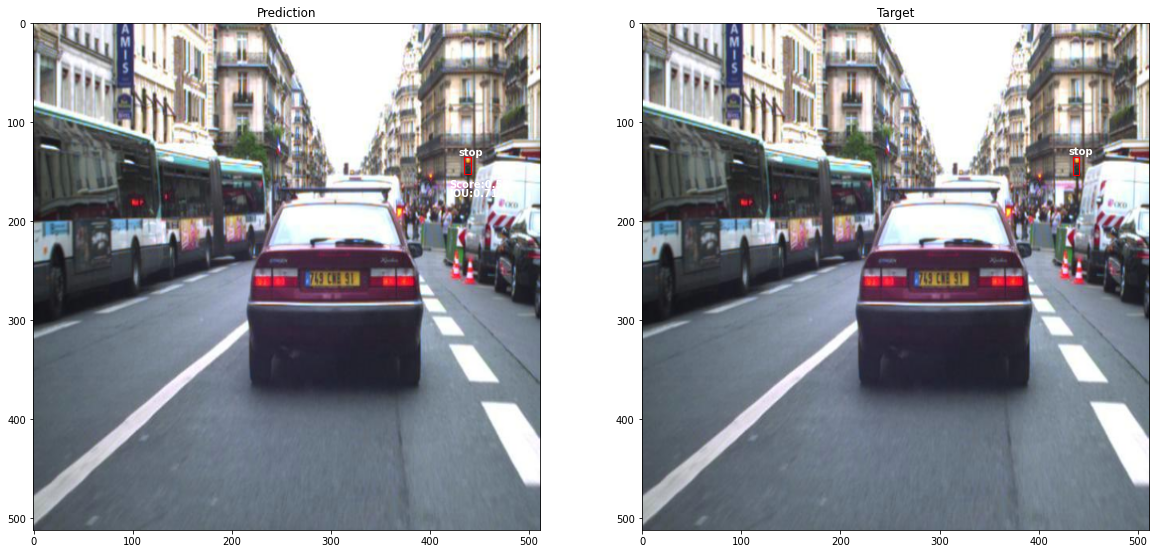

In [355]:
make_figure(im_bad, targ_bad, pred_bad)

Above is a test image I found while trying to find a 'bad' result.  Here, 'bad' means the objectness score was less than 0.6 but more than 0.5.  Surprisingly, the IOU is still around 0.7, despite the light being very far away and almost obstructed.

In [334]:
# This cell captures an 'ambiguous' example.

im_amb = None
targ_amb = None
pred_amb = None
cont = True
for batch in test_loader:
    if cont == False:
        break
    images, targets = batch
    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
    with torch.no_grad():
    model.eval()
    pred = model(images, targets)
    for t in range(len(targets)):
        labels = targets[t]['labels']
        for l in range(labels.size()[0]):
            if labels[l].item() == 4:
                im_amb = images[t]/255
                targ_amb = targets[t]
                pred_amb = pred[t]
                cont = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


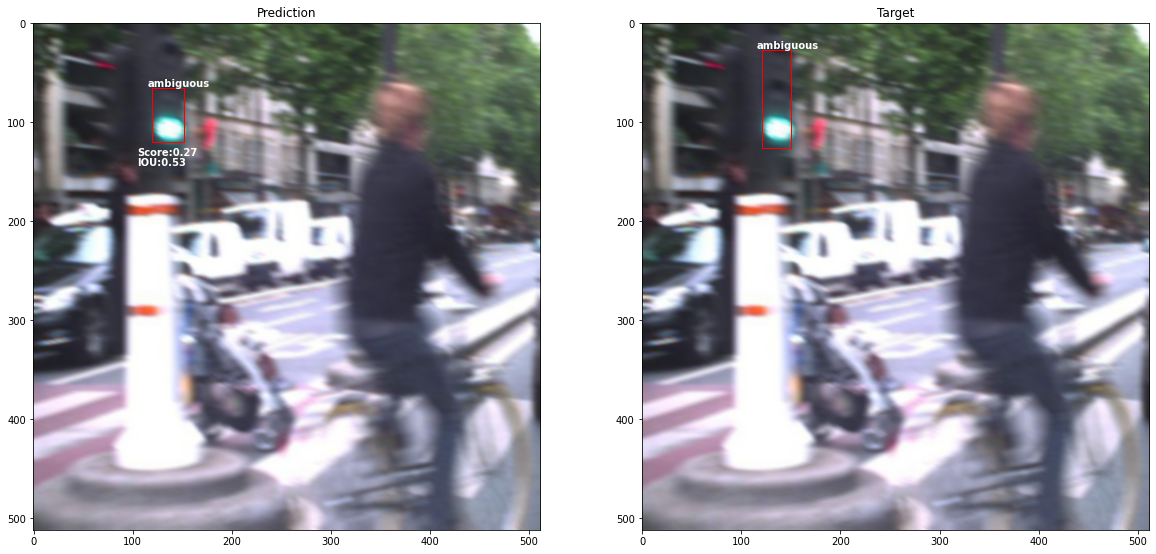

In [358]:
make_figure(im_amb, targ_amb, pred_amb)

Finally, I thought it would be interesting to look at an 'ambiguous' example.  The results were not so good.  The objectness score is 0.27 and the IOU is only 0.53.  Clearly, to the human eye, this light is green.  But, according to the website for the dataset, any image that was blurry was automatically classified as ambiguous.  Surprisingly, the network still 'correctly' classifies the image as ambiguous.  However, after seeing this image, I am concerned about the way in which the designers of the dataset classified ambiguous images.  This light is clearly not ambiguous, and I wonder this 'ambiguous' class just confuses the network.

## Looking at the effect of the size of the target bounding boxes

In [279]:
scores = []
IOU = []
area = []
corr = []


for batch in test_loader:
    images, targets = batch
    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
    with torch.no_grad():
        model.eval()
        pred = model(images, targets)
    for p in range(len(pred)):
        for i in range(pred[p]['boxes'].size()[0]):
            ious = []
            for j in range(targets[p]['boxes'].size()[0]):
                pred_bx, targ_bx = get_boxes(pred[p]['boxes'][i], targets[p]['boxes'][j])
                iou = intersection_over_union(targ_bx, pred_bx)
                ious.append(iou)
            max_iou = max(ious)
            IOU.append(max_iou)
            max_idx = ious.index(max_iou)
            targ_label = targets[p]['labels'][max_idx].item()
            area.append(targets[p]['area'][max_idx].item())
            pred_label = pred[p]['labels'][i].item()
            scores.append(pred[p]['scores'][i].item())
            if pred_label == targ_label:
                corr.append(True)
            else:
                corr.append(False)

In [300]:
scores_true = []
scores_false = []
IOU_true = []
IOU_false = []
area_true = []
area_false = []

for i in range(len(scores)):
    if corr[i] == True:
        scores_true.append(scores[i])
        IOU_true.append(IOU[i])
        area_true.append(area[i])
    else:
        scores_false.append(scores[i])
        IOU_false.append(IOU[i])
        area_false.append(area[i])



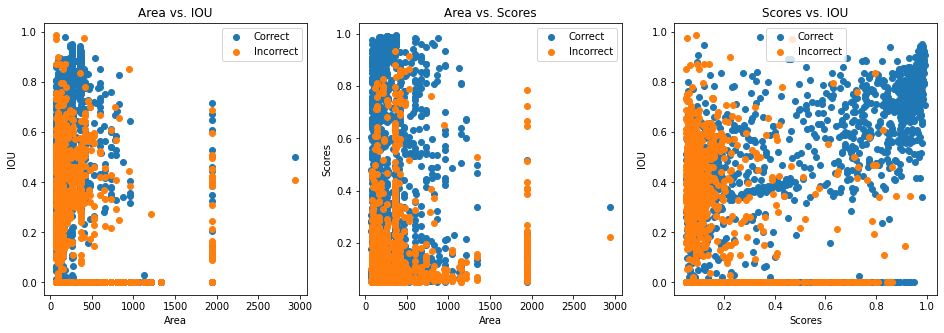

In [359]:
fig, ax = plt.subplots(1,3, figsize=(16,5))

ax[0].scatter(area_true, IOU_true, label='Correct')
ax[0].scatter(area_false, IOU_false, label='Incorrect')
ax[0].set_xlabel('Area')
ax[0].set_ylabel('IOU')
ax[0].set_title('Area vs. IOU')
ax[0].legend()
ax[1].scatter(area_true, scores_true, label='Correct')
ax[1].scatter(area_false, scores_false, label='Incorrect')
ax[1].set_xlabel('Area')
ax[1].set_ylabel('Scores')
ax[1].set_title('Area vs. Scores')
ax[1].legend()
ax[2].scatter(scores_true, IOU_true, label='Correct')
ax[2].scatter(scores_false, IOU_false, label='Incorrect')
ax[2].set_xlabel('Scores')
ax[2].set_ylabel('IOU')
ax[2].set_title('Scores vs. IOU')
ax[2].legend()
plt.show()

Above are scatter plots comparing the area of the ground truth boxes to the IOU and objectness scores.  A blue dot signifies an example that was classified correctly (i.e., as 'stop,' 'go,' etc.), and an orange dot signifies an example that was classified incorrectly.  I was very surprised to see that there is no correlation between area and IOU or scores.  This counters my expectation that larger bounding boxes would make detection easier.  Perhaps this is a sign that the model is not easily interpretable, or that it is in some way poorly calibrated.  In particular, it is interesting that there are so many boxes with almost 0 area, yet the network gave predictions with wildly varying IOUs from as low as 0 and as high as 1.  However, it is assuring to see that incorrectly classified lights typically have lower area and objectness scores compared to correctly classified lights.  Another concern I have looking at these two graphs is all the points with almost exactly the same area, around 2,000.  Since the images were acquired via a car driving around urban streets and taken at equal time intervals, there are a number of images in which there is no change in the character of the stop light.  I thought that I had mitigated this by randomly selecting subsets of the full dataset, but perhaps this was not effective enough.

The third plot compares the objectness scores and the IOU.  Again, it is conerning that there are so many images with 0 IOU but nonetheless have very hight scores.  There are also an alarming number of images with high IOUs but low scores.  At least in this plot we see somewhat nice clustering of the incorrect and correct images.  Correctly classified images typically had higher IOUS and scores, while the opposite was usually true for incorrectly classified images, as expected.

## Conclusion

In this report, I evaluated the Faster-RCNN model on the LaRA traffic light dataset.  I expected this to be a challenging dataset for the network, as the traffic lights were fairly small in most of the images, and classifying lights as 'green,' 'stop,' etc., might be difficult in an urban setting.  The precision-recall curve for the 'stop' class turned out the best, while the 'go' and 'ambiguous' curves were not so great.  The average precision for each class was also disappointing compared to the over 0.7 mAP the network has achieved on COCO and other standard datasets.  So, it seems this dataset was a bit of a challenge for the network.  Perhaps, the network needs more fine tuning.  Also, I discussed my concerns about the quality of the dataset labels and the tightness of the bounding boxes.  This also may have had a negative effect.  Perhaps more and better data would give better results.

If I had more time, I would have liked to try different backbones for the network.  Also, it would have been interesting to further fine tune the network and see if this improved the results.